# Step 1: Load All Dataset Files

Import All the Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 Load all datasets from Google Drive

In [ ]:
base_path = '/content/drive/MyDrive/'

print("Loading Azure Predictive Maintenance Dataset...")

# Load all 5 CSV files

telemetry = pd.read_csv(base_path + 'PdM_telemetry.csv', parse_dates=["datetime"])
errors = pd.read_csv(base_path + 'PdM_errors.csv', parse_dates=["datetime"])
maint = pd.read_csv(base_path + 'PdM_maint.csv', parse_dates=["datetime"])
failures = pd.read_csv(base_path + 'PdM_failures.csv', parse_dates=["datetime"])
machines = pd.read_csv(base_path + 'PdM_machines.csv')

Loading Azure Predictive Maintenance Dataset...


# Step 2: Exploratory Data Analysis (EDA)

### 2.1 Basic Dataset Overview

In [ ]:
print("Dataset loaded successfully!")

# Basic info about each dataset
datasets = {
    'Telemetry': telemetry,
    'Errors': errors,
    'Maintenance': maint,
    'Failures': failures,
    'Machines': machines
}

# Convert datetime column
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])

for name, df in datasets.items():
    print(f"\n{name} Dataset:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

Dataset loaded successfully!

Telemetry Dataset:
Shape: (876100, 6)
Columns: ['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration']

Errors Dataset:
Shape: (3919, 3)
Columns: ['datetime', 'machineID', 'errorID']

Maintenance Dataset:
Shape: (3286, 3)
Columns: ['datetime', 'machineID', 'comp']

Failures Dataset:
Shape: (761, 3)
Columns: ['datetime', 'machineID', 'failure']

Machines Dataset:
Shape: (100, 3)
Columns: ['machineID', 'model', 'age']


In [ ]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


### 2.2 Telemetry Data Analysis

Telemetry Time Coverage

In [ ]:
# Time range and machine count
print("Telemetry time range:", telemetry['datetime'].min(), "to", telemetry['datetime'].max())
print("Total unique machines:", telemetry['machineID'].nunique())

time_diffs = telemetry['datetime'].diff().dropna()
most_common_diff = time_diffs.mode()[0]
print("Time difference between measurements:", most_common_diff)


Telemetry time range: 2015-01-01 06:00:00 to 2016-01-01 06:00:00
Total unique machines: 100
Time difference between measurements: 0 days 01:00:00


Summary Statistics of Telemetory Sensors

In [ ]:
sensor_cols = ['volt', 'rotate', 'pressure', 'vibration']
print(telemetry[sensor_cols].describe())

                volt         rotate       pressure      vibration
count  876100.000000  876100.000000  876100.000000  876100.000000
mean      170.777736     446.605119     100.858668      40.385007
std        15.509114      52.673886      11.048679       5.370361
min        97.333604     138.432075      51.237106      14.877054
25%       160.304927     412.305714      93.498181      36.777299
50%       170.607338     447.558150     100.425559      40.237247
75%       181.004493     482.176600     107.555231      43.784938
max       255.124717     695.020984     185.951998      76.791072


Sensor correlation heatmap

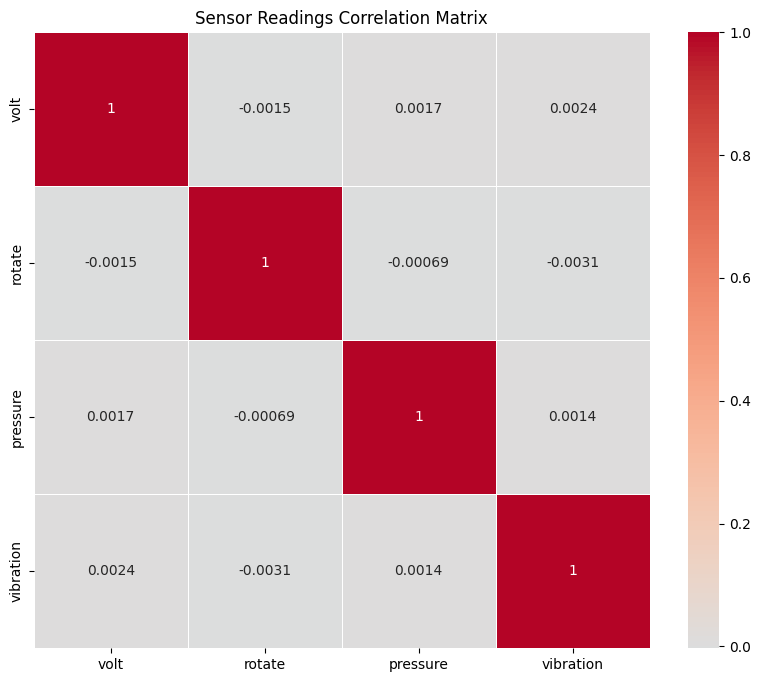

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = telemetry[sensor_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Sensor Readings Correlation Matrix')
plt.show()

Extreme Outliers

volt outliers: 7466
rotate outliers: 8568
pressure outliers: 15587
vibration outliers: 11111


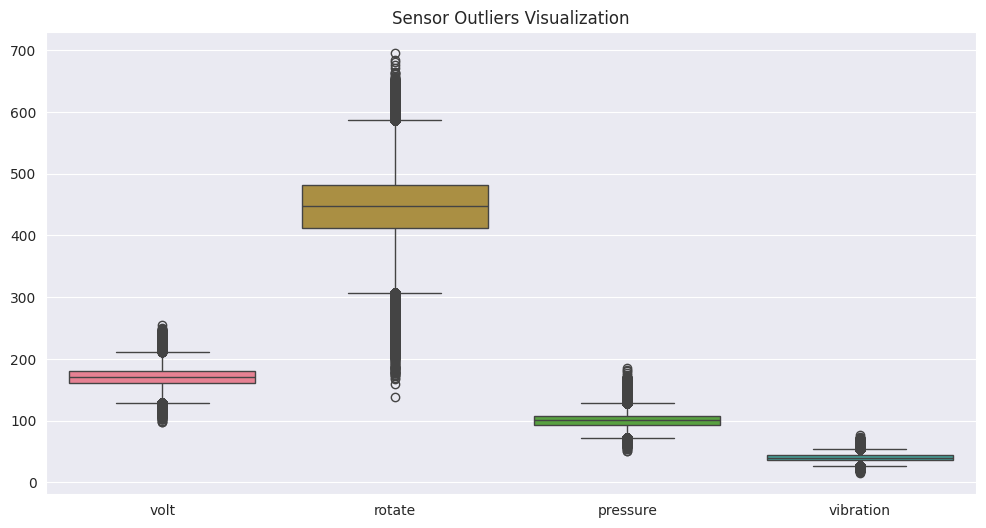

In [ ]:
# Check sensor ranges
sensor_cols = ['volt', 'rotate', 'pressure', 'vibration']

for col in sensor_cols:
    Q1 = telemetry[col].quantile(0.25)
    Q3 = telemetry[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = telemetry[(telemetry[col] < Q1 - 1.5*IQR) | (telemetry[col] > Q3 + 1.5*IQR)]
    print(f"{col} outliers: {len(outliers)}")

sns.boxplot(data=telemetry[sensor_cols])
plt.title("Sensor Outliers Visualization")
plt.show()


In [ ]:
import plotly.express as px

plot_df = telemetry.loc[(telemetry['machineID'] == 99) &
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) &
                        (telemetry['datetime'] < pd.to_datetime('2015-02-01')), ['datetime', 'volt']]

fig = px.line(x=plot_df['datetime'].values, y=plot_df['volt'].values, title='Voltage over time', template='plotly_dark')
fig.update_layout(xaxis_title='Time', yaxis_title='Voltage')
fig.show()

Time series plots for sensor readings

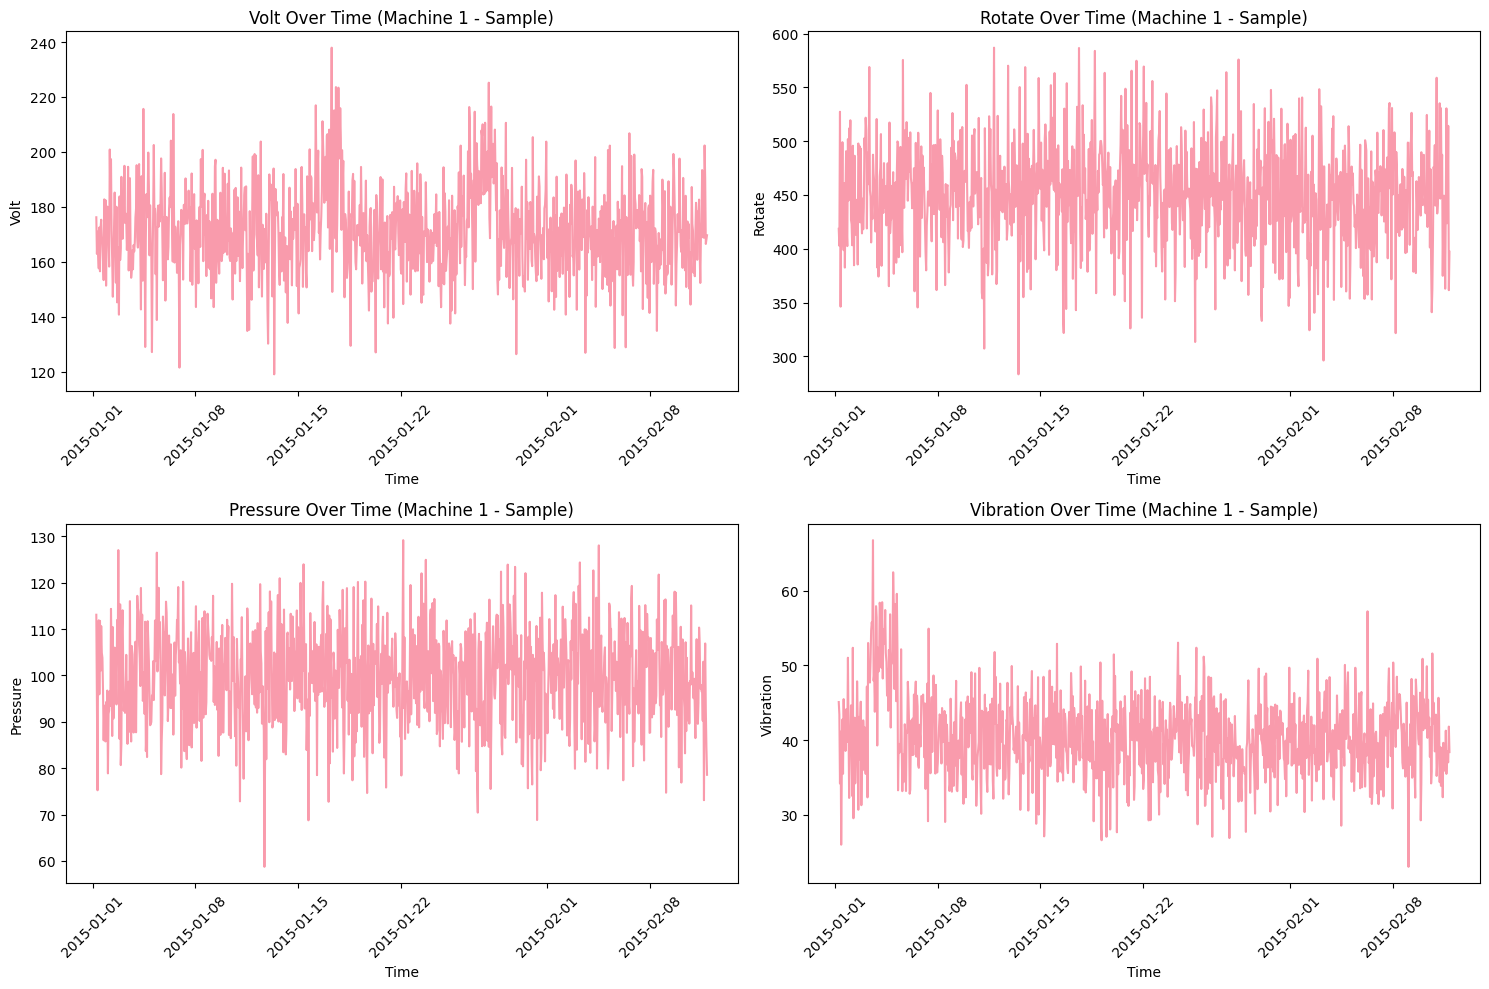

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(sensor_cols):
    # Sample data for visualization (first machine, first 1000 points)
    sample_data = telemetry[telemetry['machineID'] == 1].head(1000)
    axes[i].plot(sample_data['datetime'], sample_data[col], alpha=0.7)
    axes[i].set_title(f'{col.capitalize()} Over Time (Machine 1 - Sample)')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(col.capitalize())
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Distribution of sensor readings

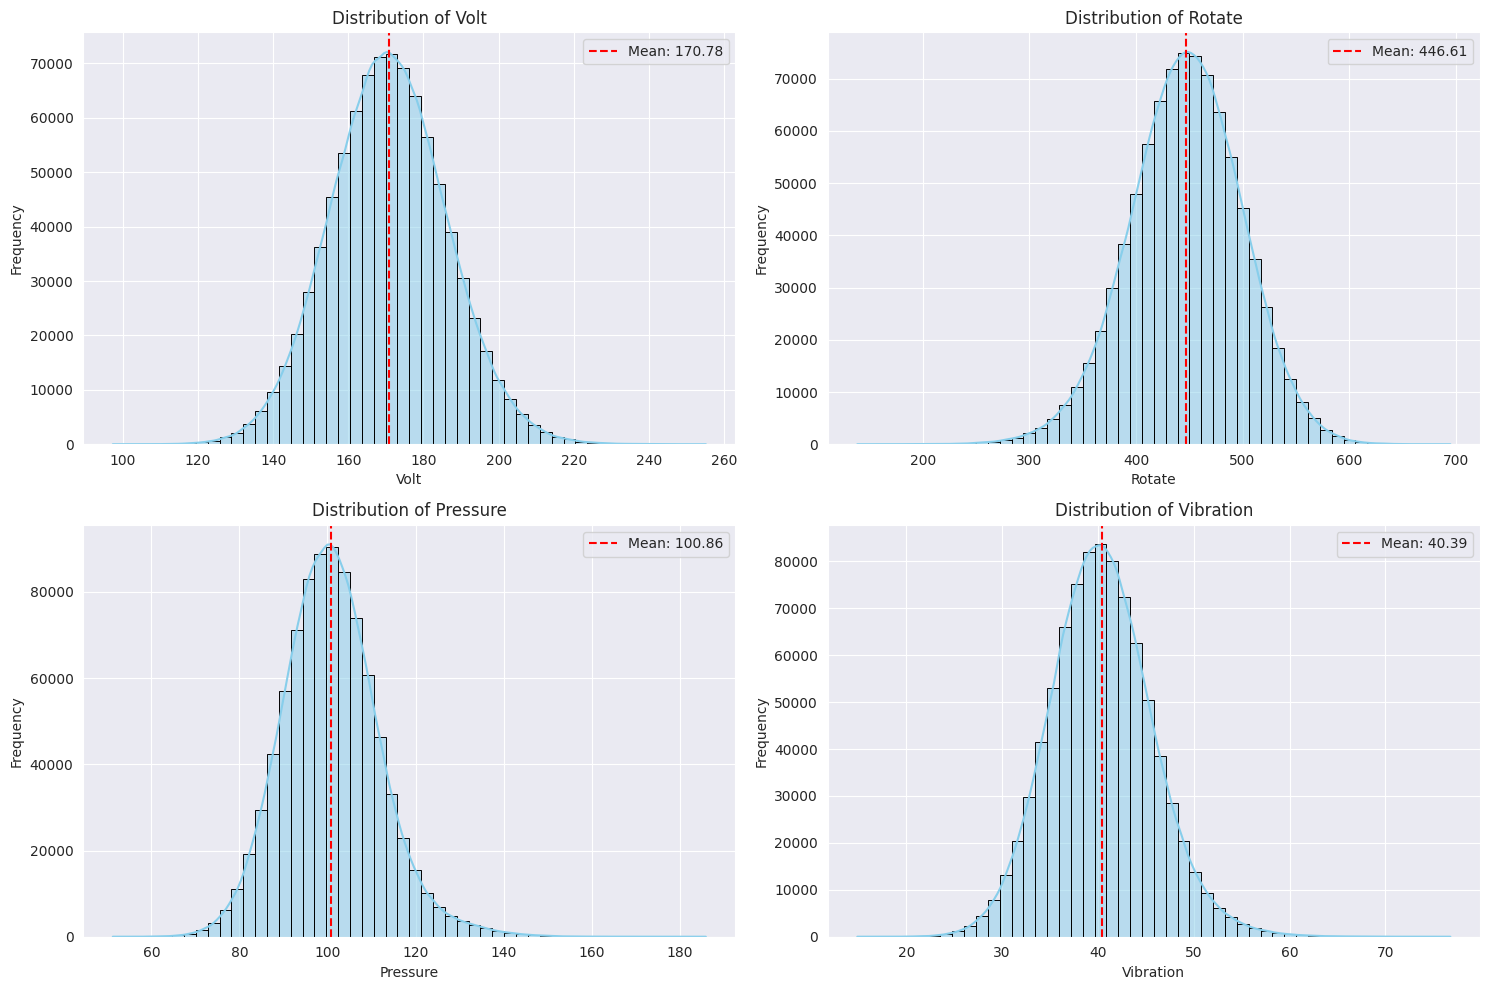

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(sensor_cols):
    sns.histplot(telemetry[col], bins=50, kde=True, color='skyblue', edgecolor='black', ax=axes[i])

    axes[i].set_title(f'Distribution of {col.capitalize()}')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Frequency')

    axes[i].axvline(telemetry[col].mean(), color='red', linestyle='--',
                    label=f'Mean: {telemetry[col].mean():.2f}')
    axes[i].legend()

plt.tight_layout()
plt.show()


Proving Distribution Type

=== Skewness & Kurtosis ===
volt: Skewness = 0.09, Kurtosis = 3.12
rotate: Skewness = -0.14, Kurtosis = 3.20
pressure: Skewness = 0.40, Kurtosis = 3.88
vibration: Skewness = 0.25, Kurtosis = 3.47

=== Shapiro-Wilk Test ===
volt: Shapiro-Wilk p-value = 0.0014
  -> volt does NOT look normal
rotate: Shapiro-Wilk p-value = 0.0002
  -> rotate does NOT look normal
pressure: Shapiro-Wilk p-value = 0.0000
  -> pressure does NOT look normal
vibration: Shapiro-Wilk p-value = 0.0000
  -> vibration does NOT look normal

=== Q-Q Plots ===


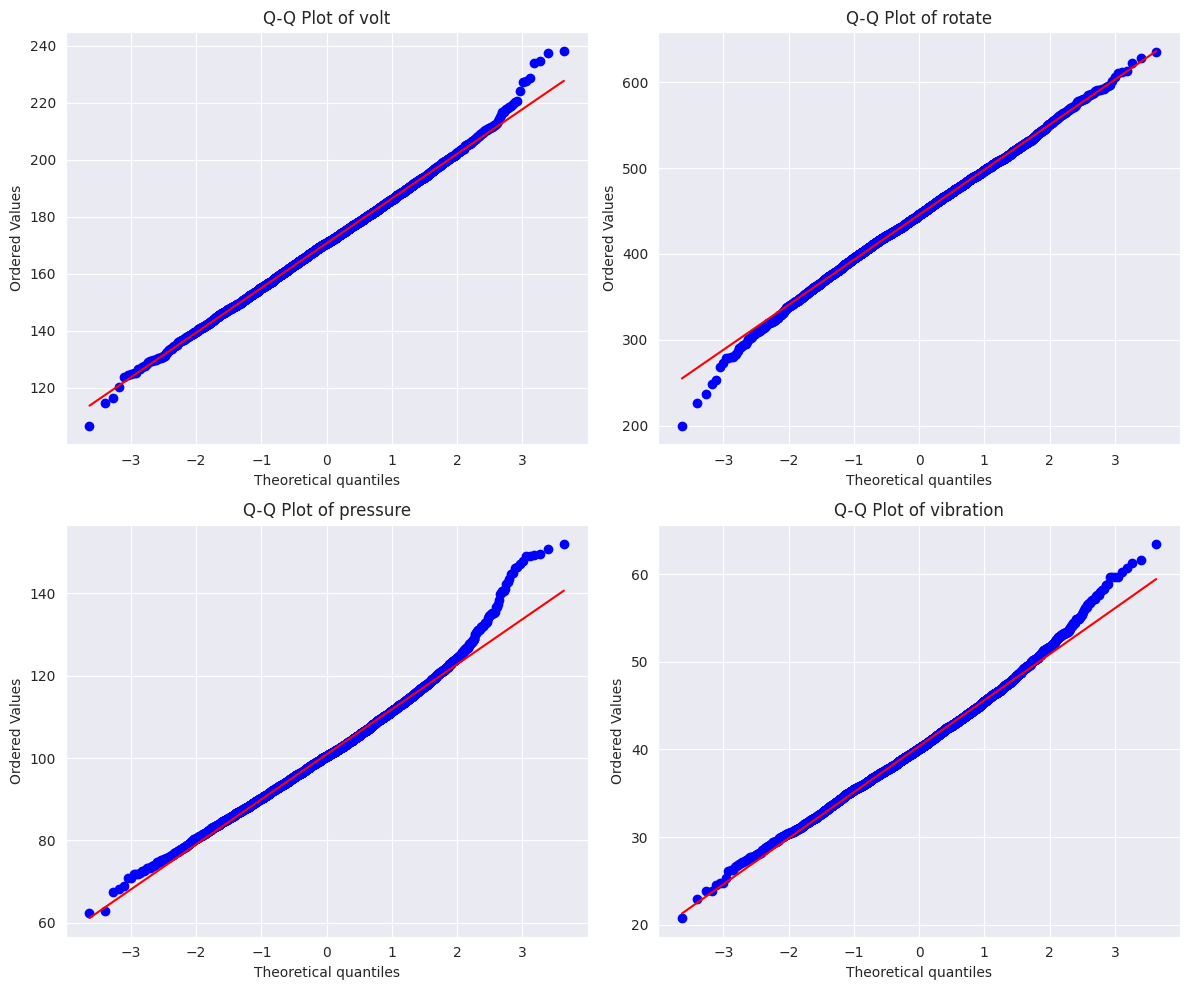

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, shapiro, probplot

sensor_cols = ['volt', 'rotate', 'pressure', 'vibration']

# 1. Skewness & Kurtosis
print("=== Skewness & Kurtosis ===")
for col in sensor_cols:
    s = skew(telemetry[col])
    k = kurtosis(telemetry[col], fisher=False)  # compare to 3
    print(f"{col}: Skewness = {s:.2f}, Kurtosis = {k:.2f}")

# 2. Shapiro-Wilk Test
sample_size = 5000
print("\n=== Shapiro-Wilk Test ===")
for col in sensor_cols:
    data_sample = telemetry[col].sample(sample_size, random_state=42)
    stat, p = shapiro(data_sample)
    print(f"{col}: Shapiro-Wilk p-value = {p:.4f}")
    if p > 0.05:
        print(f"  -> {col} looks normal")
    else:
        print(f"  -> {col} does NOT look normal")

# 3. Q-Q Plots
print("\n=== Q-Q Plots ===")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, col in enumerate(sensor_cols):
    probplot(telemetry[col].sample(sample_size, random_state=42), dist="norm", plot=axes[i])
    axes[i].set_title(f"Q-Q Plot of {col}")

plt.tight_layout()
plt.show()


# 2.3 Machine Data Analysis

Machine distribution by model and age

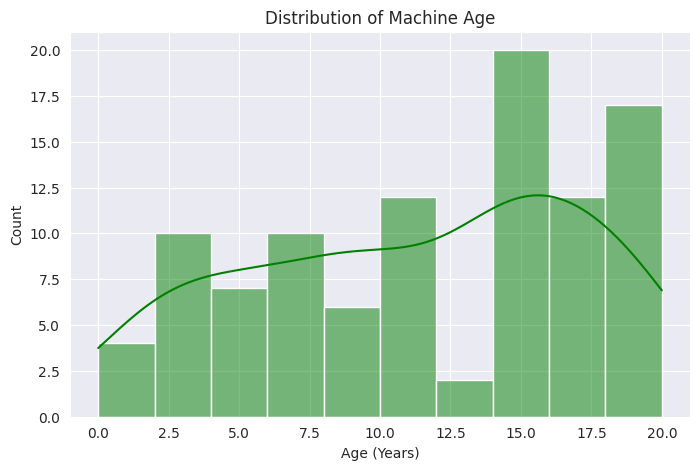

Machine statistics by model:
          age               machineID
         mean   std min max     count
model                                
model1  12.25  5.39   2  20        16
model2  12.76  5.85   2  20        17
model3  12.03  5.61   1  20        35
model4   9.34  6.10   0  20        32


In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(machines['age'], bins=10, kde=True, color='green')
plt.title("Distribution of Machine Age")
plt.xlabel("Age (Years)")
plt.ylabel("Count")
plt.show()


print("Machine statistics by model:")
print(machines.groupby('model').agg({
    'age': ['mean', 'std', 'min', 'max'],
    'machineID': 'count'
}).round(2))

# 2.4 Error Data Analysis

Error type distribution

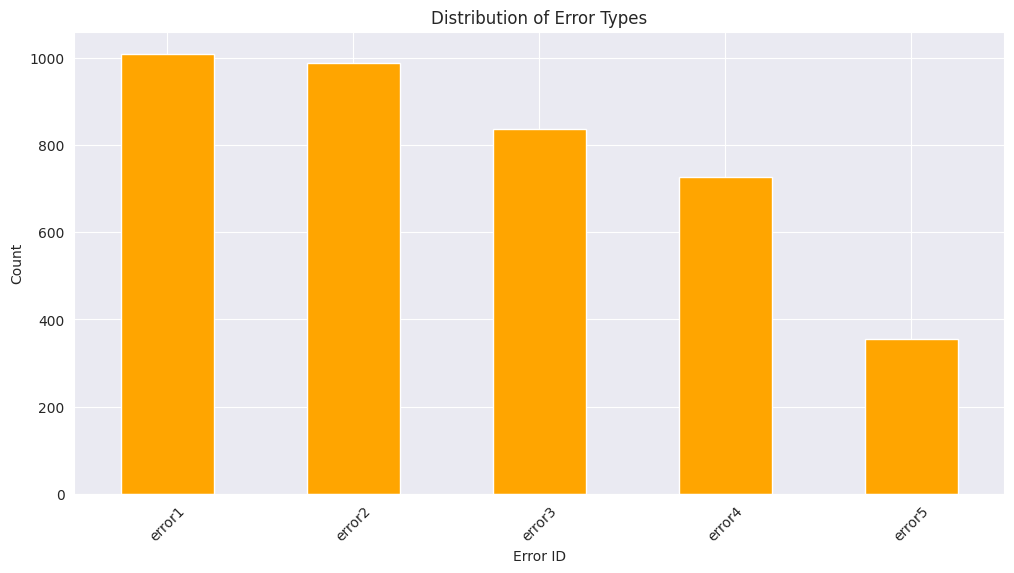

In [ ]:
# Convert datetime
errors['datetime'] = pd.to_datetime(errors['datetime'])

plt.figure(figsize=(12, 6))
error_counts = errors['errorID'].value_counts()
error_counts.plot(kind='bar', color='orange')
plt.title('Distribution of Error Types')
plt.xlabel('Error ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Error patterns by machine

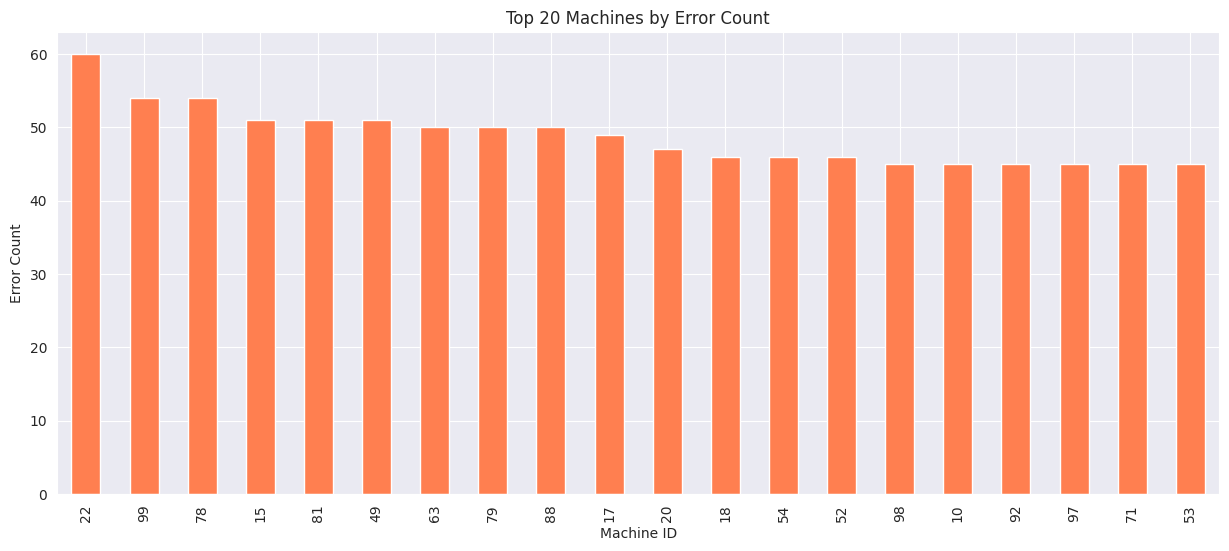

In [ ]:
error_by_machine = errors.groupby('machineID')['errorID'].count().sort_values(ascending=False)
plt.figure(figsize=(15, 6))
error_by_machine.head(20).plot(kind='bar', color='coral')
plt.title('Top 20 Machines by Error Count')
plt.xlabel('Machine ID')
plt.ylabel('Error Count')
plt.show()


#2.6 Failure Data Analysis

Failure distribution by component (our prediction target)

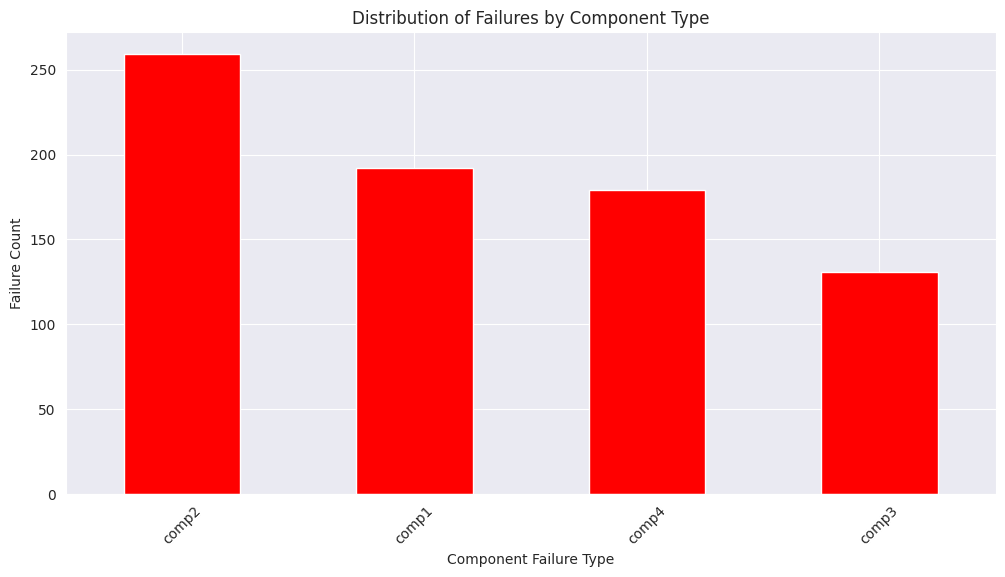

In [ ]:
# Convert datetime
failures['datetime'] = pd.to_datetime(failures['datetime'])

plt.figure(figsize=(12, 6))
failure_counts = failures['failure'].value_counts()
failure_counts.plot(kind='bar', color='red')
plt.title('Distribution of Failures by Component Type')
plt.xlabel('Component Failure Type')
plt.ylabel('Failure Count')
plt.xticks(rotation=45)
plt.show()

Failure timeline

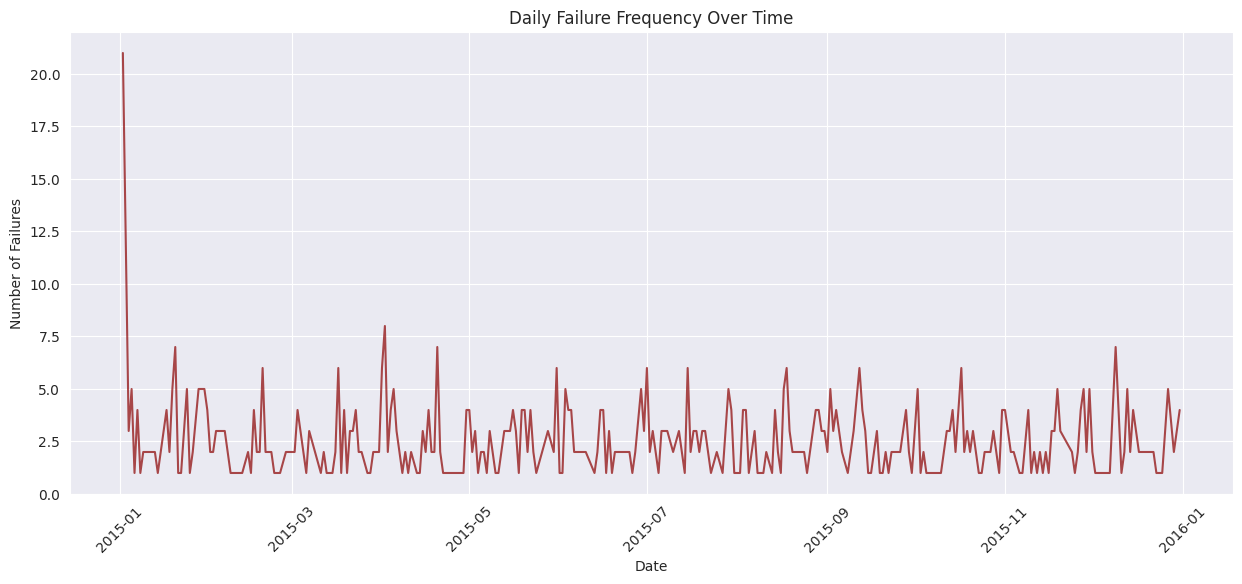

In [ ]:
failures['date'] = failures['datetime'].dt.date
daily_failures = failures.groupby('date').size()

plt.figure(figsize=(15, 6))
daily_failures.plot(kind='line', color='darkred', alpha=0.7)
plt.title('Daily Failure Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Failures')
plt.xticks(rotation=45)
plt.show()

Failures by machine

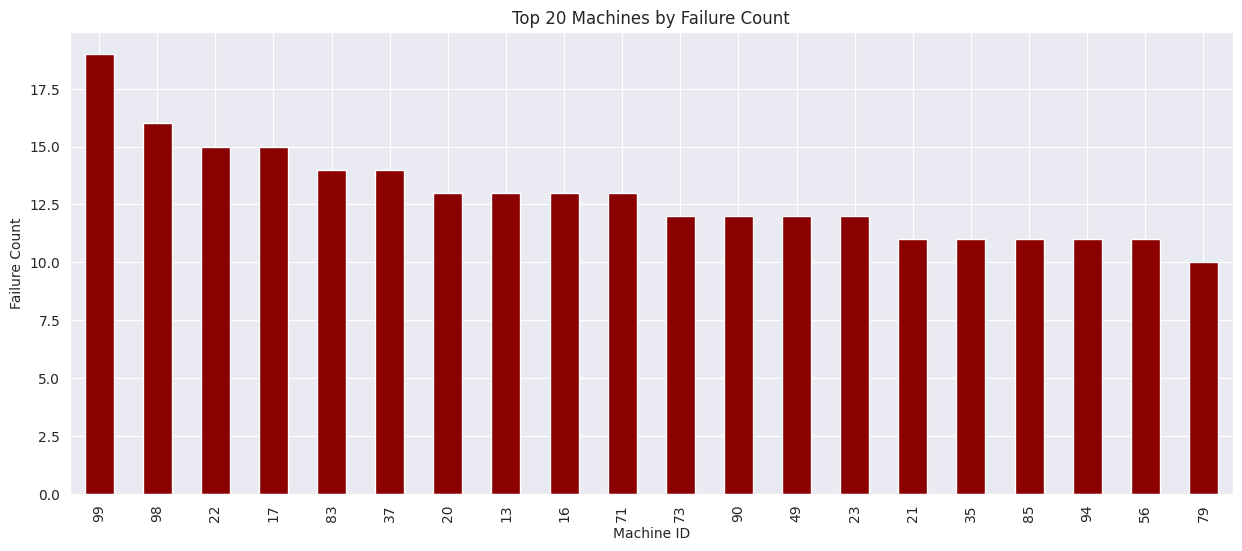


Failure statistics:
Total failures: 761
Unique machines with failures: 98


In [ ]:
failure_by_machine = failures.groupby('machineID')['failure'].count().sort_values(ascending=False)
plt.figure(figsize=(15, 6))
failure_by_machine.head(20).plot(kind='bar', color='darkred')
plt.title('Top 20 Machines by Failure Count')
plt.xlabel('Machine ID')
plt.ylabel('Failure Count')
plt.show()

print("\nFailure statistics:")
print(f"Total failures: {len(failures)}")
print(f"Unique machines with failures: {failures['machineID'].nunique()}")

## 2.7 Check for Missing Values

In [ ]:
# Check for missing values
print("Missing values analysis:")
for name, df in datasets.items():
    missing = df.isnull().sum()
    print(f"\n{name}:")
    if missing.sum() == 0:
        print("  No missing values")
    else:
        print(missing[missing > 0])

Missing values analysis:

Telemetry:
  No missing values

Errors:
  No missing values

Maintenance:
  No missing values

Failures:
  No missing values

Machines:
  No missing values


## 2.8 Check for Duplicates

In [ ]:
def check_duplicates(df, name, subset=None):
    print(f"\nChecking duplicates in {name}")

    if subset is not None:
        dups = df[df.duplicated(subset=subset, keep=False)]
    else:
        dups = df[df.duplicated(keep=False)]

    print(f"Total duplicates found: {len(dups)}")

    if not dups.empty:
        print("Examples of duplicate rows:")
        print(dups.head())
    else:
        print("No duplicates found.")

check_duplicates(telemetry, "Telemetry",
                 subset=['machineID', 'datetime', 'volt', 'rotate', 'pressure', 'vibration'])

check_duplicates(errors, "Errors",
                 subset=['machineID', 'datetime', 'errorID'])

check_duplicates(failures, "Failures",
                 subset=['machineID', 'datetime', 'failure'])

check_duplicates(maint, "Maintenance",
                 subset=['machineID', 'datetime', 'comp'])

check_duplicates(machines, "Machines")



Checking duplicates in Telemetry
Total duplicates found: 0
No duplicates found.

Checking duplicates in Errors
Total duplicates found: 0
No duplicates found.

Checking duplicates in Failures
Total duplicates found: 0
No duplicates found.

Checking duplicates in Maintenance
Total duplicates found: 0
No duplicates found.

Checking duplicates in Machines
Total duplicates found: 0
No duplicates found.


## 2.9 Summary Statistics for Transofmer Models

In [ ]:
print("Dataset Summary for PatchTST and MOMENT Models:")
print(f"• Total machines: {telemetry['machineID'].nunique()}")
print(f"• Time series length: {len(telemetry)} total observations")
print(f"• Average time series per machine: {len(telemetry) / telemetry['machineID'].nunique():.0f} points")
print(f"• Sensor features: {len(sensor_cols)} (volt, rotate, pressure, vibration)")
print(f"• Total failures: {len(failures)}")
print(f"• Failure types: {failures['failure'].nunique()}")
print(f"• Time range: {telemetry['datetime'].min()} to {telemetry['datetime'].max()}")

# Feature correlation with upcoming failures (simple analysis)
print(f"\nPrediction Windows Analysis:")
for window in [24, 48, 72]:
    failure_count = len(failures)
    print(f"• {window}h window: {failure_count} failure events to predict")

Dataset Summary for PatchTST and MOMENT Models:
• Total machines: 100
• Time series length: 876100 total observations
• Average time series per machine: 8761 points
• Sensor features: 4 (volt, rotate, pressure, vibration)
• Total failures: 761
• Failure types: 4
• Time range: 2015-01-01 06:00:00 to 2016-01-01 06:00:00

Prediction Windows Analysis:
• 24h window: 761 failure events to predict
• 48h window: 761 failure events to predict
• 72h window: 761 failure events to predict


# Step 3: Create Target Variables (24h/48h/72h)


### 3.1 Merging Datasets

In [ ]:
# Step 1: Merge telemetry + machines
df = pd.merge(telemetry, machines, on='machineID', how='left')

# Step 2: One-hot encode 'model' into 0/1 columns
df = pd.get_dummies(df, columns=['model'], prefix='', prefix_sep='')
# Now columns are 'model1', 'model2', 'model3', 'model4'
df[[c for c in df.columns if c.startswith('model')]] = df[[c for c in df.columns if c.startswith('model')]].astype(int)

# Step 3: One-hot encode errors by type
errors_onehot = pd.get_dummies(errors, columns=['errorID'], prefix='', prefix_sep='')

# Aggregate errors: sum up per machine + datetime
errors_agg = errors_onehot.groupby(['machineID', 'datetime']).sum().reset_index()

# Step 4: Merge aggregated errors with df
df_merged = df.merge(errors_agg, on=['machineID', 'datetime'], how='left')

# Step 5: Fill NaN with 0 for error columns
error_cols = [c for c in df_merged.columns if c.startswith('error')]
df_merged[error_cols] = df_merged[error_cols].fillna(0).astype(int)

### 3.2 Creating Target variables

In [ ]:
import pandas as pd

# Ensure datetime columns are datetime
df_merged['datetime'] = pd.to_datetime(df_merged['datetime'])
failures['datetime'] = pd.to_datetime(failures['datetime'])

# Sort datasets
df_merged = df_merged.sort_values(['machineID', 'datetime']).reset_index(drop=True)
failures = failures.sort_values(['machineID', 'datetime']).reset_index(drop=True)

# Step 1: Aggregate failures (handle duplicates by one-hot + collapse)
failures_onehot = pd.get_dummies(failures, columns=['failure'], prefix='', prefix_sep='')
failures_agg = failures_onehot.groupby(['machineID', 'datetime']).max().reset_index()
failures_agg = failures_agg.rename(columns={'datetime': 'failure_time'})

# Step 2: Merge_asof per machine to align rows with *next failure*
df_list = []
for machine_id, df_machine in df_merged.groupby('machineID'):
    failures_machine = failures_agg[failures_agg['machineID'] == machine_id]
    df_with_fail = pd.merge_asof(
        df_machine,
        failures_machine,
        left_on='datetime',
        right_on='failure_time',
        direction='forward'
    )
    df_list.append(df_with_fail)

df_final = pd.concat(df_list).reset_index(drop=True)

# Step 3: Create binary target labels
time_diff = (df_final['failure_time'] - df_final['datetime']).dt.total_seconds()

df_final['will_fail_24h'] = ((time_diff > 0) & (time_diff <= 24*3600)).astype(int)
df_final['will_fail_48h'] = ((time_diff > 0) & (time_diff <= 48*3600)).astype(int)
df_final['will_fail_72h'] = ((time_diff > 0) & (time_diff <= 72*3600)).astype(int)

# Optional: fill NA values in component flags if no failure matched
df_final[['comp1','comp2','comp3','comp4']] = df_final[['comp1','comp2','comp3','comp4']].fillna(0).astype(int)

# Drop the duplicate machineID column
df_final = df_final.drop(columns=['machineID_y'])

# Rename machineID_x to machineID for clarity
df_final = df_final.rename(columns={'machineID_x': 'machineID'})

# Reset index
df_final = df_final.reset_index(drop=True)

In [ ]:
# Drop columns not needed for training
df_train = df_final.drop(columns=['failure_time', 'comp1', 'comp2', 'comp3', 'comp4'])

In [ ]:
# Count how many 0s and 1s in each target
print(df_train[['will_fail_24h', 'will_fail_48h', 'will_fail_72h']].sum())
print(df_train[['will_fail_24h', 'will_fail_48h', 'will_fail_72h']].value_counts())
print(f"Percentage of positive cases: {df_train['will_fail_24h'].mean()*100:.2f}%")
print(f"Percentage of positive cases: {df_train['will_fail_48h'].mean()*100:.2f}%")
print(f"Percentage of positive cases: {df_train['will_fail_72h'].mean()*100:.2f}%")

will_fail_24h    17183
will_fail_48h    33959
will_fail_72h    50735
dtype: int64
will_fail_24h  will_fail_48h  will_fail_72h
0              0              0                825365
1              1              1                 17183
0              0              1                 16776
               1              1                 16776
Name: count, dtype: int64
Percentage of positive cases: 1.96%
Percentage of positive cases: 3.88%
Percentage of positive cases: 5.79%


Checking merging and targets validity

In [ ]:
# Make sure: will_fail_24h <= will_fail_48h <= will_fail_72h
mask = ~((df_train['will_fail_24h'] <= df_train['will_fail_48h']) &
         (df_train['will_fail_48h'] <= df_train['will_fail_72h']))
print("Rows with inconsistent targets:", df_train[mask])


Rows with inconsistent targets: Empty DataFrame
Columns: [datetime, machineID, volt, rotate, pressure, vibration, age, model1, model2, model3, model4, error1, error2, error3, error4, error5, will_fail_24h, will_fail_48h, will_fail_72h]
Index: []


In [ ]:
# Recalculate boolean directly
correct_flag = ((df_final['failure_time'] - df_final['datetime']).dt.total_seconds() > 0) & \
               ((df_final['failure_time'] - df_final['datetime']).dt.total_seconds() <= 24*3600)

# Compare with your column
errors = df_final[df_final['will_fail_24h'] != correct_flag.astype(int)]

print(f"Number of mismatches: {len(errors)}")

Number of mismatches: 0


# Step 4: Data Preprocessing

Checking missing and duplicate values

In [ ]:
print("Missing values per column:")
print(df_train.isnull().sum())
print("\nNumber of duplicate rows:", df_train.duplicated().sum())

Missing values per column:
datetime         0
machineID        0
volt             0
rotate           0
pressure         0
vibration        0
age              0
model1           0
model2           0
model3           0
model4           0
error1           0
error2           0
error3           0
error4           0
error5           0
will_fail_24h    0
will_fail_48h    0
will_fail_72h    0
dtype: int64

Number of duplicate rows: 0


In [ ]:
df_train.head()

,datetime,machineID,volt,rotate,pressure,vibration,age,model1,model2,model3,model4,error1,error2,error3,error4,error5,will_fail_24h,will_fail_48h,will_fail_72h
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,0,0,1,0,0,0,0,0,0,0,0,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,18,0,0,1,0,0,0,0,0,0,0,0,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,18,0,0,1,0,0,0,0,0,0,0,0,0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,18,0,0,1,0,0,0,0,0,0,0,0,0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,18,0,0,1,0,0,0,0,0,0,0,0,0


### 4.1 Feature Engineering

In [ ]:
import pandas as pd
import numpy as np

# Example: sensor columns
sensor_cols = ['volt', 'rotate', 'pressure', 'vibration']
windows = [6, 12, 24]  # rolling windows in hours

# Compute rolling features
df_train = df_train.copy()
for col in sensor_cols:
    for w in windows:
        grouped = df_train.groupby('machineID')[col]
        df_train[f'{col}_rollmean{w}h'] = grouped.rolling(window=w, min_periods=1).mean().values
        df_train[f'{col}_rollstd{w}h'] = grouped.rolling(window=w, min_periods=1).std().values
        df_train[f'{col}_rollmin{w}h'] = grouped.rolling(window=w, min_periods=1).min().values
        df_train[f'{col}_rollmax{w}h'] = grouped.rolling(window=w, min_periods=1).max().values

In [ ]:
# Fill NaN values with forward fill first, then 0
for col in df_train.columns:
    if col not in ['datetime', 'machineID']:
        df_train[col] = df_train.groupby('machineID')[col].fillna(method='ffill').fillna(0)

In [ ]:
# Define target columns
targets = ['will_fail_24h', 'will_fail_48h', 'will_fail_72h']

# Move targets to the end
cols = [c for c in df_train.columns if c not in targets] + targets
df_train = df_train[cols]

# Print all column names to verify
print(df_train.columns.tolist())


['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration', 'age', 'model1', 'model2', 'model3', 'model4', 'error1', 'error2', 'error3', 'error4', 'error5', 'volt_rollmean6h', 'volt_rollstd6h', 'volt_rollmin6h', 'volt_rollmax6h', 'volt_rollmean12h', 'volt_rollstd12h', 'volt_rollmin12h', 'volt_rollmax12h', 'volt_rollmean24h', 'volt_rollstd24h', 'volt_rollmin24h', 'volt_rollmax24h', 'rotate_rollmean6h', 'rotate_rollstd6h', 'rotate_rollmin6h', 'rotate_rollmax6h', 'rotate_rollmean12h', 'rotate_rollstd12h', 'rotate_rollmin12h', 'rotate_rollmax12h', 'rotate_rollmean24h', 'rotate_rollstd24h', 'rotate_rollmin24h', 'rotate_rollmax24h', 'pressure_rollmean6h', 'pressure_rollstd6h', 'pressure_rollmin6h', 'pressure_rollmax6h', 'pressure_rollmean12h', 'pressure_rollstd12h', 'pressure_rollmin12h', 'pressure_rollmax12h', 'pressure_rollmean24h', 'pressure_rollstd24h', 'pressure_rollmin24h', 'pressure_rollmax24h', 'vibration_rollmean6h', 'vibration_rollstd6h', 'vibration_rollmin6h', 'vibration_

In [ ]:
save_path = '/content/drive/My Drive/final_dataset.csv'
df_train.to_csv(save_path, index=False)

print(f"File saved to {save_path}")

File saved to /content/drive/My Drive/final_dataset.csv


### 4.2 Time based Train/Val/Test Split

In [ ]:
import pandas as pd
import numpy as np

# 0) Basics: ensure datetime + sort
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_train = df_train.sort_values(['machineID', 'datetime']).reset_index(drop=True)

# Cast booleans to compact ints
bool_cols = [c for c in df_train.columns if df_train[c].dtype == 'bool']
if bool_cols:
    df_train[bool_cols] = df_train[bool_cols].astype('uint8')

# 3) Time-based split (global cutoffs by datetime quantiles)
cut1, cut2 = df_train['datetime'].quantile([0.70, 0.85])
train = df_train[df_train['datetime'] <= cut1].copy()
val   = df_train[(df_train['datetime'] > cut1) & (df_train['datetime'] <= cut2)].copy()
test  = df_train[df_train['datetime'] > cut2].copy()

# 4) Imbalance report
targets = ['will_fail_24h', 'will_fail_48h', 'will_fail_72h']

def describe_split_multi(name, d, targets):
    n = len(d)
    tmin, tmax = d['datetime'].min(), d['datetime'].max()
    print(f"{name:>6}: n={n:,}  time {tmin} → {tmax}")
    for t in targets:
        pos = int(d[t].sum())
        rate = pos / n if n else 0.0
        print(f"   {t}: positives={pos:,}  rate={rate:.3%}")

describe_split_multi('train', train, targets)
describe_split_multi('  val', val, targets)
describe_split_multi(' test', test, targets)


 train: n=613,300  time 2015-01-01 06:00:00 → 2015-09-13 18:00:00
   will_fail_24h: positives=12,542  rate=2.045%
   will_fail_48h: positives=24,723  rate=4.031%
   will_fail_72h: positives=36,928  rate=6.021%
   val: n=131,400  time 2015-09-13 19:00:00 → 2015-11-07 12:00:00
   will_fail_24h: positives=2,193  rate=1.669%
   will_fail_48h: positives=4,368  rate=3.324%
   will_fail_72h: positives=6,594  rate=5.018%
  test: n=131,400  time 2015-11-07 13:00:00 → 2016-01-01 06:00:00
   will_fail_24h: positives=2,448  rate=1.863%
   will_fail_48h: positives=4,868  rate=3.705%
   will_fail_72h: positives=7,213  rate=5.489%


### 4.3 Scaling all Numerical Features

In [ ]:
from sklearn.preprocessing import StandardScaler

# Identify columns to scale (exclude identifiers and all targets)
cols_to_exclude = ['datetime', 'machineID', 'will_fail_24h', 'will_fail_48h', 'will_fail_72h']
feature_cols = [col for col in train.columns if col not in cols_to_exclude]

print(f"Scaling {len(feature_cols)} features...")

# Fit scaler ONLY on training data
scaler = StandardScaler()
scaler.fit(train[feature_cols])

# Transform all splits using training statistics
train_scaled = train.copy()
val_scaled = val.copy()
test_scaled = test.copy()

train_scaled[feature_cols] = scaler.transform(train[feature_cols])
val_scaled[feature_cols] = scaler.transform(val[feature_cols])
test_scaled[feature_cols] = scaler.transform(test[feature_cols])

print("Scaling completed!")
print("Train scaled shape:", train_scaled.shape)
print("Val scaled shape:", val_scaled.shape)
print("Test scaled shape:", test_scaled.shape)

Scaling 62 features...
Scaling completed!
Train scaled shape: (613300, 67)
Val scaled shape: (131400, 67)
Test scaled shape: (131400, 67)


# Step 5: Training Baseline Model (XGBoost)


==================== TARGET: will_fail_24h ====================


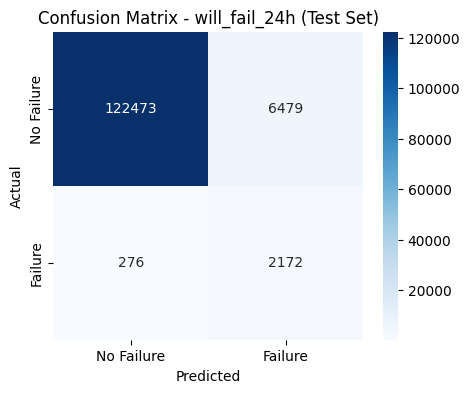


=== TRAINING SET REPORT ===
              precision    recall  f1-score   support

  No Failure       1.00      0.95      0.98    600758
     Failure       0.32      1.00      0.48     12542

    accuracy                           0.96    613300
   macro avg       0.66      0.98      0.73    613300
weighted avg       0.99      0.96      0.97    613300


=== VALIDATION SET REPORT ===
              precision    recall  f1-score   support

  No Failure       1.00      0.95      0.97    129207
     Failure       0.23      0.89      0.37      2193

    accuracy                           0.95    131400
   macro avg       0.62      0.92      0.67    131400
weighted avg       0.99      0.95      0.96    131400


=== TEST SET REPORT ===
              precision    recall  f1-score   support

  No Failure       1.00      0.95      0.97    128952
     Failure       0.25      0.89      0.39      2448

    accuracy                           0.95    131400
   macro avg       0.62      0.92      0.68

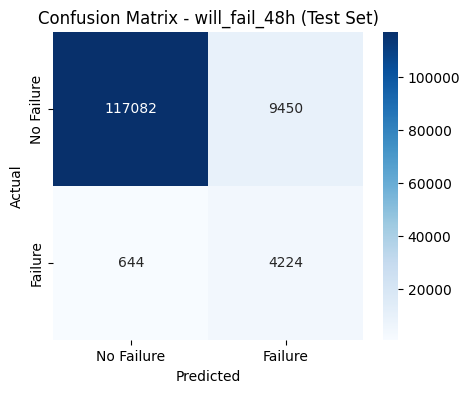


=== TRAINING SET REPORT ===
              precision    recall  f1-score   support

  No Failure       1.00      0.93      0.96    588577
     Failure       0.36      0.93      0.52     24723

    accuracy                           0.93    613300
   macro avg       0.68      0.93      0.74    613300
weighted avg       0.97      0.93      0.94    613300


=== VALIDATION SET REPORT ===
              precision    recall  f1-score   support

  No Failure       1.00      0.93      0.96    127032
     Failure       0.29      0.88      0.44      4368

    accuracy                           0.92    131400
   macro avg       0.64      0.90      0.70    131400
weighted avg       0.97      0.92      0.94    131400


=== TEST SET REPORT ===
              precision    recall  f1-score   support

  No Failure       0.99      0.93      0.96    126532
     Failure       0.31      0.87      0.46      4868

    accuracy                           0.92    131400
   macro avg       0.65      0.90      0.71

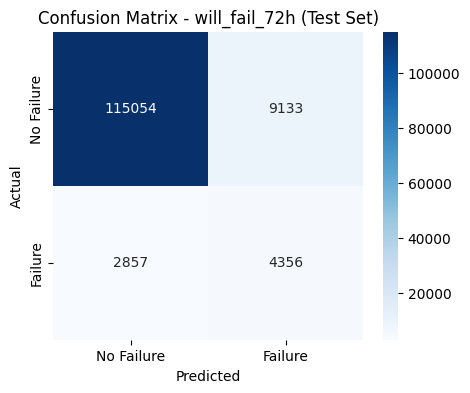


=== TRAINING SET REPORT ===
              precision    recall  f1-score   support

  No Failure       0.98      0.93      0.96    576372
     Failure       0.39      0.66      0.49     36928

    accuracy                           0.92    613300
   macro avg       0.68      0.80      0.72    613300
weighted avg       0.94      0.92      0.93    613300


=== VALIDATION SET REPORT ===
              precision    recall  f1-score   support

  No Failure       0.98      0.93      0.95    124806
     Failure       0.31      0.60      0.41      6594

    accuracy                           0.91    131400
   macro avg       0.64      0.77      0.68    131400
weighted avg       0.94      0.91      0.93    131400


=== TEST SET REPORT ===
              precision    recall  f1-score   support

  No Failure       0.98      0.93      0.95    124187
     Failure       0.32      0.60      0.42      7213

    accuracy                           0.91    131400
   macro avg       0.65      0.77      0.69

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Prepare data function
def prepare_data(dataset, target):
    """Extract features and target from dataset"""
    feature_cols = [col for col in dataset.columns
                    if col not in ['datetime', 'machineID', 'will_fail_24h',
                                   'will_fail_48h', 'will_fail_72h']]
    X = dataset[feature_cols]
    y = dataset[target]
    return X, y

# 2) Function for business evaluation
def business_evaluation(y_true, y_pred, dataset_name):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Business costs (example values)
    emergency_repair_cost = 10000  # Missing a failure
    unnecessary_maintenance_cost = 500  # False alarm

    total_emergency_cost = fn * emergency_repair_cost
    total_unnecessary_cost = fp * unnecessary_maintenance_cost
    total_cost = total_emergency_cost + total_unnecessary_cost

    print(f"\n=== BUSINESS METRICS - {dataset_name.upper()} ===")
    print(f"Failures caught: {tp}/{tp+fn} ({recall:.1%})")
    print(f"Precision (when we predict failure, we're right): {precision:.1%}")
    print(f"Missed failures (emergencies): {fn} → ${total_emergency_cost:,}")
    print(f"False alarms (extra maintenance): {fp} → ${total_unnecessary_cost:,}")
    print(f"Total cost: ${total_cost:,}")

    return recall, precision

# 3) Loop over all three targets
targets = ['will_fail_24h', 'will_fail_48h', 'will_fail_72h']

for target in targets:
    print(f"\n==================== TARGET: {target} ====================")

    # Prepare data
    X_train, y_train = prepare_data(train_scaled, target)
    X_val, y_val = prepare_data(val_scaled, target)
    X_test, y_test = prepare_data(test_scaled, target)

    # Handle imbalance
    neg_count = (y_train == 0).sum()
    pos_count = (y_train == 1).sum()
    scale_pos_weight = neg_count / pos_count

    # Train XGBoost
    xgb_model = xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight*0.4,
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42,
        eval_metric='aucpr'
    )
    xgb_model.fit(X_train, y_train)

    # Predictions
    train_pred = xgb_model.predict(X_train)
    val_pred = xgb_model.predict(X_val)
    test_pred = xgb_model.predict(X_test)
    # Print confusion matrix
    cm_test = confusion_matrix(y_test, test_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure','Failure'], yticklabels=['No Failure','Failure'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - {target} (Test Set)')
    plt.show()

    # Classification reports
    print("\n=== TRAINING SET REPORT ===")
    print(classification_report(y_train, train_pred, target_names=['No Failure','Failure']))
    print("\n=== VALIDATION SET REPORT ===")
    print(classification_report(y_val, val_pred, target_names=['No Failure','Failure']))
    print("\n=== TEST SET REPORT ===")
    print(classification_report(y_test, test_pred, target_names=['No Failure','Failure']))

    # Business evaluation
    business_evaluation(y_train, train_pred, "training")
    business_evaluation(y_val, val_pred, "validation")

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print("\n=== TOP 10 FEATURES ===")
    print(feature_importance.head(10))
